
<br><br><br>
<h2><font color="#AD0B0B" size=6>Movie search engine: Data collection, manipulation and storage from IMDB and TMDB</font></h2>



<br><br>
<div style="text-align: right">


</div>

I will work with various movie data sources and extract information using different techniques:

- IMDB: The famous movie database website, where I will extract data from a clone using web scraping.
- IMDB: I will also work with its data dumps to carry out a process of merging information.
- TMDB: I will utilize this popular API to extract information that complements the previous data.

Finally, I will integrate part of the information into a MongoDB database, which will enable me to implement a movie search engine.

## <font color="#AD0B0B"> IMDB´s movie list  </font>
<br>

_Internet Movie Database ( [IMDb](http://www.imdb.com) )_ is one of the reference sites for movies and series on the Internet. Among other things, it stores information about casts, plots, budgets, etc. In addition, it contains numerous ratings and reviews provided by users. All this information is potentially accessible and recoverable automatically through __scraping__, although __IMDb expressly prohibits this type of access__, unless authorized.

### <font color="#AD0B0B">Web scraping of IMDB´s dump. </font>
<br>

Due to the impossibility of obtaining authorization for such projects, I will work with a small IMDb *dump* available at http://c3-capstone2.jialonso.com. This *dump* contains the top 10 highest-rated movies on IMDb and is a reduced version of the list of the top 250 movies available at https://www.imdb.com/chart/top.

First, let's import the libraries I will use for web scraping.

In [1]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd

The home page contains the list of movies and the link to each of their individual pages. The first thing I am going to do is to obtain a list with all the links.

In [2]:
def get_links(url):
    res = requests.get(url)
    soup = BeautifulSoup(res.content)
    
    match = re.search('(https?://.+?)/', url)
    if match:
        base_url = match.group(1)
    else:
        base_url = url
        
    link_tags = soup.select('td.titleColumn a')
    return [f'{base_url}{a_tag.get("href")}' for a_tag in link_tags]
    
links = get_links('http://c3-capstone2.jialonso.com')
print(links)

['http://c3-capstone2.jialonso.com/tt0111161.html', 'http://c3-capstone2.jialonso.com/tt0068646.html', 'http://c3-capstone2.jialonso.com/tt0071562.html', 'http://c3-capstone2.jialonso.com/tt0468569.html', 'http://c3-capstone2.jialonso.com/tt0050083.html', 'http://c3-capstone2.jialonso.com/tt0108052.html', 'http://c3-capstone2.jialonso.com/tt0167260.html', 'http://c3-capstone2.jialonso.com/tt0110912.html', 'http://c3-capstone2.jialonso.com/tt0060196.html', 'http://c3-capstone2.jialonso.com/tt0137523.html']


The next step is to obtain the basic information of each movie. For each of them I want to obtain a dictionary with the following format:

    {
        'id': 'tt0068646',
        'title': {
            'primary': 'El padrino',
            'original': 'The Godfather'
        },
        'year': 1972,
        'genres': ['Crime', 'Drama'],
        'runtimeMinutes': 175
    }
    
This information can be obtained from the movie header on the web, as shown in the following image:

<a id="inicio"></a>
<img src="img/el_padrino.png" alt="El padrino webscraping">

This is a function called `duration_string_to_minutes`, which transforms strings of type `Xh YYmin' (eg 2h 24min) into duration in minutes (eg 144). To do this, I use a **regular expression** that detects the number of minutes and hours in the string. For simplicity, it can be assumed that the minimum duration of the movies is 1 hour.

In [3]:
def duration_string_to_minutes(duration):
    """
    Converts the string duration to the integer minutes.
    For example: duration_string_to_minutes("1h 37m") = 97
    """
    match = re.findall(r'\d+', duration)
    if len(match)>1:
        return int(match[0])*60+int(match[1])
    else:
        return int(match[0])*60

In [4]:
assert duration_string_to_minutes('2h 30min') == 150
assert duration_string_to_minutes('2h') == 120

I create the `get_movie_info` function that given the url of a movie in the IMDB *dump* gets the id, primary and original title, year, genre(s) and duration. The returned result will be a dictionary with the format presented above.

In [5]:
def get_movie_info(url):
   
    res = requests.get(url)
    soup = BeautifulSoup(res.content)
    genres=[]
            
    _id = url.split('/')[-1].split('.')[0]
    title_wrapper = soup.select_one('div.title_wrapper')
    
    title_primary_tag = title_wrapper.select_one('h1') 
    title_original_tag = title_wrapper.select_one('div.originalTitle')
    year_tag = title_wrapper.select_one('h1 a')
    genres_tags = title_wrapper.find_all('a', href=re.compile(r'.*genre*'))
    runtime_tag = title_wrapper.select_one('div.subtext time')
    for genre in genres_tags: genres.append(genre.text)
            
    return {
        'id': _id,
        'title': {
            'primary': re.split(r"\xa0", str(title_primary_tag.contents[0]))[0], 
            'original': title_original_tag.contents[0] if title_original_tag != None else re.split(r"\xa0", str(title_primary_tag.contents[0]))[0]
        },
        'year': year_tag.text,
        'genres': genres,
        'runtimeMinutes': duration_string_to_minutes(str(runtime_tag.text))
    }


In [6]:
data = [get_movie_info(link) for link in links]
print(data)

[{'id': 'tt0111161', 'title': {'primary': 'Cadena perpetua', 'original': 'The Shawshank Redemption'}, 'year': '1994', 'genres': ['Drama'], 'runtimeMinutes': 142}, {'id': 'tt0068646', 'title': {'primary': 'El padrino', 'original': 'The Godfather'}, 'year': '1972', 'genres': ['Crime', 'Drama'], 'runtimeMinutes': 175}, {'id': 'tt0071562', 'title': {'primary': 'El padrino: Parte II', 'original': 'The Godfather: Part II'}, 'year': '1974', 'genres': ['Crime', 'Drama'], 'runtimeMinutes': 202}, {'id': 'tt0468569', 'title': {'primary': 'El caballero oscuro', 'original': 'The Dark Knight'}, 'year': '2008', 'genres': ['Action', 'Crime', 'Drama'], 'runtimeMinutes': 152}, {'id': 'tt0050083', 'title': {'primary': '12 hombres sin piedad', 'original': '12 Angry Men'}, 'year': '1957', 'genres': ['Drama'], 'runtimeMinutes': 96}, {'id': 'tt0108052', 'title': {'primary': 'La lista de Schindler', 'original': "Schindler's List"}, 'year': '1993', 'genres': ['Biography', 'Drama', 'History'], 'runtimeMinutes':

In [7]:
assert data[1]["runtimeMinutes"] == 175
assert data[7]["title"]["original"] == "Pulp Fiction"

The `data` object, in dictionary list format, can be imported into a pandas dataframe using the `json_normalize` method.

In [8]:
from pandas import json_normalize

df_webscraping = json_normalize(data)
df_webscraping.set_index('id', inplace=True)
df_webscraping.head()

,year,genres,runtimeMinutes,title.primary,title.original
id,,,,,
tt0111161,1994,[Drama],142,Cadena perpetua,The Shawshank Redemption
tt0068646,1972,"[Crime, Drama]",175,El padrino,The Godfather
tt0071562,1974,"[Crime, Drama]",202,El padrino: Parte II,The Godfather: Part II
tt0468569,2008,"[Action, Crime, Drama]",152,El caballero oscuro,The Dark Knight
tt0050083,1957,[Drama],96,12 hombres sin piedad,12 Angry Men




### <font color="#AD0B0B"> Complete list of IMDB movies. </font>
<br>

In the previous section, the web scraping process, although it is possible, is very slow and I do not have a complete *dump* of IMDB. For this reason I will use a file with the basic data of more than 400,000 films. This archive contains films after the year 1927, that is, the year in which the first film projection with sound took place.

The file is a *zip* file that contains a json file for each year, between 1928 and 2019. Each of these files has the same structure as the `data` object obtained in the previous section.

I can download and unzip the *zip* file directly from python:

In [68]:
import io
import json
import os
import zipfile

if not os.path.exists('data/imdb/movies/'):
    url = 'http://c3-capstone2.jialonso.com/data/movies-json.zip'
    res = requests.get(url)
    obj = io.BytesIO(res.content)

    with zipfile.ZipFile(obj) as zip_ref:
        zip_ref.extractall('data/imdb/movies/')

The next step is to read these JSON files and create a single dataframe with the information of all the movies.

In [10]:
def get_basics_df():
    """
    This method returns a dataframe with the data of all the movies contained in the file
    movies-json.zip
    """
    path = 'data/imdb/movies/'
    df = pd.DataFrame()
    json_files = [pos_json for pos_json in os.listdir(path) if pos_json.endswith('.json')]
    for file in json_files:
        df_file = pd.read_json(path+file).to_dict(orient="records")
        df_file = json_normalize(df_file)
        df=pd.concat([df, df_file])
    df.set_index('id', inplace=True)
    return df

In [11]:
df_basics = get_basics_df()
df_basics.head()

,year,runtimeMinutes,genres,title.original,title.primary
id,,,,,
tt0011715,1928,NaN,"[Drama, Romance]",Sol de gloria,Sol de gloria
tt0016788,1928,NaN,None,O Diabo em Lisboa,O Diabo em Lisboa
tt0016970,1928,84.0,[Drama],La hija del mestre,La hija del mestre
tt0017516,1928,NaN,None,Violantha,Violantha
tt0017621,1928,108.0,"[Drama, Fantasy, Horror]",Alraune,A Daughter of Destiny


In [12]:
assert set(df_basics.columns) == {"year", "runtimeMinutes", "genres", "title.original", "title.primary"}
assert len(df_basics) == 415633

In [13]:
df_basics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 415633 entries, tt0011715 to tt9363342
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            415633 non-null  int64  
 1   runtimeMinutes  300940 non-null  float64
 2   genres          358188 non-null  object 
 3   title.original  415633 non-null  object 
 4   title.primary   415633 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 19.0+ MB





### <font color="#AD0B0B"> Ratings file uploading </font>
<br>

_IMDB_ makes some updated datasets publicly available in `csv` format [(link)](https://datasets.imdbws.com). I will use the `title.ratings.gz` file that contains information about the ratings given to each movie. Also note the existence of the `title.basics.tsv.gz` file that contains information very similar to that provided in the previous section.

In [14]:
def get_df_ratings():
    return pd.read_table('https://datasets.imdbws.com/title.ratings.tsv.gz', compression='gzip', index_col='tconst')

In [15]:
df_ratings = get_df_ratings()
df_ratings.head()

,averageRating,numVotes
tconst,,
tt0000001,5.7,1989
tt0000002,5.8,265
tt0000003,6.5,1851
tt0000004,5.5,178
tt0000005,6.2,2635


In [16]:
assert set(df_ratings.columns) == {"averageRating", "numVotes"}

In [17]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1334305 entries, tt0000001 to tt9916880
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   averageRating  1334305 non-null  float64
 1   numVotes       1334305 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 30.5+ MB





### <font color="#AD0B0B"> Creation of the initial dataset </font>
<br>

Since the number of titles is still high, only those titles that have received the most attention will be considered. I select titles that have received more (strictly) than 50,000 votes.

In [18]:
def filter_df_ratings(min_votes):
    """
    Filters the df_ratings dataframe and returns a new dataframe in which all rows have at least min_votes
    """
    return df_ratings[df_ratings['numVotes']>min_votes]
    

In [19]:
df_ratings = filter_df_ratings(50000)
df_ratings.head()
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4600 entries, tt0000417 to tt9906260
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   averageRating  4600 non-null   float64
 1   numVotes       4600 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 107.8+ KB


In [20]:
assert df_ratings["numVotes"].min() > 50000

Once both data sets have been delimited, a single set will be created, which will be called `df_movies`, and which will contain the movies that appear in both, that is:

* films made after 1927
* have received more than 50000 votes.

In [21]:
df_basics

,year,runtimeMinutes,genres,title.original,title.primary
id,,,,,
tt0011715,1928,NaN,"[Drama, Romance]",Sol de gloria,Sol de gloria
tt0016788,1928,NaN,None,O Diabo em Lisboa,O Diabo em Lisboa
tt0016970,1928,84.0,[Drama],La hija del mestre,La hija del mestre
tt0017516,1928,NaN,None,Violantha,Violantha
tt0017621,1928,108.0,"[Drama, Fantasy, Horror]",Alraune,A Daughter of Destiny
...,...,...,...,...,...
tt9359696,2019,NaN,[Documentary],The Big Jump 3D,The Big Jump 3D
tt9359768,2019,NaN,[Comedy],Different,Different
tt9359866,2019,75.0,[Drama],Pink Hill,Pink Hill


In [24]:
def join_dataframes():
    """
    Joins the df_basics and df_ratings dataframes and returns the resulting dataframe
    """
    return pd.merge(df_ratings, df_basics, how='left', left_index=True, right_index=True)

In [25]:
print("The final number of titles is {:d}".format(len(df_ratings)))

df_movies = join_dataframes()
df_movies.info()

The final number of titles is 4600
<class 'pandas.core.frame.DataFrame'>
Index: 4600 entries, tt0000417 to tt9906260
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   averageRating   4600 non-null   float64
 1   numVotes        4600 non-null   int64  
 2   year            3681 non-null   float64
 3   runtimeMinutes  3563 non-null   float64
 4   genres          3681 non-null   object 
 5   title.original  3681 non-null   object 
 6   title.primary   3681 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 416.5+ KB


In [26]:
assert set(df_movies.columns) == {"year", "runtimeMinutes", "genres", "title.original", "title.primary", "averageRating", "numVotes"}

Finally, the relevant data will be kept (some discarded data will be updated later).

Keep only the `'title.primary'`, `'genres'`, `'averageRating'`, and `'numVotes'` columns from `df_movies`. Rename them as `'title'`,`'genres'`,`'avg_rating'`, and `'num_votes`. Rename the index as `movie_id `.

In [27]:
def select_columns():
    """
    Select the columns from the df_movies dataframe and return the new dataframe
    """
    return df_movies.rename(columns = {'title.primary': 'title', 'averageRating': 'avg_rating', 'numVotes':'num_votes'}).rename_axis('movie_id', axis=0, inplace=False)[['title','genres','avg_rating','num_votes']]

In [28]:
df_movies = select_columns()
df_movies.head()

,title,genres,avg_rating,num_votes
movie_id,,,,
tt0000417,NaN,NaN,8.2,52965
tt0010323,NaN,NaN,8.0,67155
tt0012349,NaN,NaN,8.3,130459
tt0013442,NaN,NaN,7.9,101480
tt0015324,NaN,NaN,8.2,53337


In [29]:
assert set(df_movies.columns) == {"title", "genres", "avg_rating", "num_votes"}
assert df_movies.index.name == "movie_id"

To illustrate some examples in the project, I will use the movie with identifier`'tt0068646'`: ___The Godfather___.

In [31]:
tgf_movie_id = 'tt0068646'
df_movies.loc[tgf_movie_id]

title          The Godfather
genres        [Crime, Drama]
avg_rating               9.2
num_votes            1932108
Name: tt0068646, dtype: object

<a id="section2"></a>
## <font color="#AD0B0B">The Movie Database (TMDb)  </font>

<br>

_The Movie Database ([TMDB](https://www.themoviedb.org))_ is another web resource that contains information about movies and series, and was raised as an alternative to _IMDb_. To this day, its use as a means of collecting criticism and evaluations _is practically nil_. However, it contains complete and up-to-date information about movies, and it provides a very complete REST API. In this project I will use the _TMDb_ API to extend the initial data set.

The _TMDb_ API requires authentication, so to work with it it is necessary, first of all, to have a user. Once the registration on the site is done, it is necessary to request a key for the use of the API. Detailed instructions are shown on this page ([link](https://developers.themoviedb.org/3/getting-started/introduction)). This process is simple, and basically consists of 3 steps:

1. Enter the personal account settings.
2. Enter the API menu.
3. Create the API.

Later it is possible to access, within the account configuration, the section corresponding to the API. In it are several access tokens. In this project we need the first one, labeled _API Key (v3 auth)_. Copy this token and assign it to the `token` variable.

In [55]:
token = 'your_API_token'

The _TMDb_ API is accessible via `https://api.themoviedb.org/3/`. All the _endpoints_ it provides can be found in the documentation ([link](https://developers.themoviedb.org/3/getting-started/introduction)). In addition, from this site it is possible to test the methods, and generate the calls in various languages. In the case of _Python_ two alternatives are generated. The former uses the `http.client` library, while the latter uses `requests`.

---

### <font color="#AD0B0B"> Obtaining information about each movie.</font>

<br>

The `GET /movie/{movie_id}` call allows you to get information about a movie. The `movie_id` field corresponds to the identifier of the movie, which can be _TMDb_'s own, or the identifier in _IMDb_ (which is what I have). One of the parameters it takes is `language`, which in this project will be set to `en_US`.

In [33]:
import requests
import json

language = 'en_US'
params = {'api_key':token, 'language':language}

Get information about the movie _The Godfather_ (whose code is `'tt0068646'` and is stored in `tgf_movie_id`).

In [34]:
def get_one_movie(movie_id):
    """
   Returns a dictionary with the movie data received as a parameter from the TMDB API
    """
    return requests.get(f"https://api.themoviedb.org/3/movie/{tgf_movie_id}", params).json()

In [35]:
tgf_data = get_one_movie(tgf_movie_id)
print(json.dumps(tgf_data, indent=3))

{
   "adult": false,
   "backdrop_path": "/tmU7GeKVybMWFButWEGl2M4GeiP.jpg",
   "belongs_to_collection": {
      "id": 230,
      "name": "The Godfather Collection",
      "poster_path": "/e5iVtjkjM30znn86JsvkBYtvEo1.jpg",
      "backdrop_path": "/3WZTxpgscsmoUk81TuECXdFOD0R.jpg"
   },
   "budget": 6000000,
   "genres": [
      {
         "id": 18,
         "name": "Drama"
      },
      {
         "id": 80,
         "name": "Crime"
      }
   ],
   "homepage": "http://www.thegodfather.com/",
   "id": 238,
   "imdb_id": "tt0068646",
   "original_language": "en",
   "original_title": "The Godfather",
   "overview": "Spanning the years 1945 to 1955, a chronicle of the fictional Italian-American Corleone crime family. When organized crime family patriarch, Vito Corleone barely survives an attempt on his life, his youngest son, Michael steps in to take care of the would-be killers, launching a campaign of bloody revenge.",
   "popularity": 156.311,
   "poster_path": "/3bhkrj58Vtu7enYsRolD1

In [36]:
assert tgf_data["release_date"] == "1972-03-14"

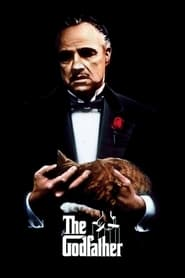

In [37]:
from IPython.display import Image
Image('http://image.tmdb.org/t/p/w185'+tgf_data['poster_path'])


Once the access to a movie's data via the _TMDb_ API has been implemented, the data related to all the movies referenced in `df_movies` will be obtained, and it will be stored in a JSON structure that will be called `movie_data`.

<div class="alert alert-block alert-danger">
    
<i class="fa fa-exclamation-triangle" aria-hidden="true"></i> Each API call requires approximately 0.5 seconds. Therefore, obtaining the data for all the films may require, if done sequentially, around 1500 seconds. Due to this, and in order to facilitate the development of the work in different sessions, it is convenient to store the results in a file, which will be called `data/backup/movie_data.json`. Once this file is available, in subsequent work sessions, the data will be read from here.
</div>

In [39]:
def get_movie_data():
    json_data = {}
    for idx, row in df_movies.iterrows():
        json_data.update({idx: requests.get(f"https://api.themoviedb.org/3/movie/{idx}", params).json()})
    return json_data

In [40]:
import os

# If the data has not been downloaded yet, it downloads and stores it in the file
if not os.path.isfile('data/backup/movie_data.json'):
    # Donwload the data
    movie_data = get_movie_data()
    
    with open('data/backup/movie_data.json',"w") as movie_data_file:
        json.dump(movie_data, movie_data_file)    
        
# If they were previously downloaded, and the file is available, it reads them.
else:
    with open('data/backup/movie_data.json','r') as movie_data_file:
        movie_data = json.load(movie_data_file)
    
    
print("The number of titles obtained is {:d}".format(len(movie_data)))

The number of titles obtained is 4390


In [41]:
assert movie_data[tgf_movie_id]["release_date"] == "1972-03-14"

---

### <font color="#00586D"> Adding information to the data set.</font>

<br>

Once the data relative to each movie has been obtained and stored in the `movie_data` structure, the relevant information must be incorporated into the _DataFrame_ `df_movies`. Specifically, columns will be created that contain, for each movie, the following fields (the types to be used are given in parentheses):

* `budget (integer)`, which corresponds to the budget,
* `revenue (integer)`, which corresponds to the earnings,
* `release_date(TimeStamp)`, which corresponds to the release date,
* `original_language(String)`, which corresponds to the original language,
* `popularity (float)`, which corresponds to the popularity.

In [42]:
def extend_df_movies():
    """
    Add the budget, revenue, release_date, original_language, and popularity columns to the df_movies dataframe and return the resulting dataframe
    """
    
    return df_movies.join(pd.DataFrame.from_dict(movie_data, orient='index').rename_axis('movie_id', axis=0, inplace=False)[['budget','revenue','release_date','original_language','popularity','poster_path']], on='movie_id', how='left').astype({'budget':'Int64', 'revenue':'Int64', 'release_date':'datetime64',"original_language": "string","popularity":"float64"})

In [43]:
df_movies = extend_df_movies()
df_movies.head()

,title,genres,avg_rating,num_votes,budget,revenue,release_date,original_language,popularity,poster_path
movie_id,,,,,,,,,,
tt0000417,NaN,NaN,8.2,52965,5985,0,1902-04-17,fr,13.328,/9o0v5LLFk51nyTBHZSre6OB37n2.jpg
tt0010323,NaN,NaN,8.0,67155,18000,8811,1920-02-27,de,10.906,/myK9DeIsXWGKgUTZyGXg2IfFk0W.jpg
tt0012349,NaN,NaN,8.3,130459,250000,2500000,1921-01-21,en,14.097,/drgMcyTsySQBnUPGaBThCHGdlWT.jpg
tt0013442,NaN,NaN,7.9,101480,0,19054,1922-02-16,de,14.557,/zx24O7VAs6NbJhiIrUhWysAiHS0.jpg
tt0015324,NaN,NaN,8.2,53337,0,0,1924-04-17,en,10.295,/1G9r3rqtbFAQuyWKOZm4Y5J5s7Q.jpg


In [44]:
assert set(df_movies.columns) == {"title", "genres", "avg_rating", "num_votes", "budget", "revenue", "release_date", "original_language", "popularity", "poster_path"}
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4600 entries, tt0000417 to tt9906260
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   title              3681 non-null   object        
 1   genres             3681 non-null   object        
 2   avg_rating         4600 non-null   float64       
 3   num_votes          4600 non-null   int64         
 4   budget             3867 non-null   Int64         
 5   revenue            3867 non-null   Int64         
 6   release_date       3867 non-null   datetime64[ns]
 7   original_language  3867 non-null   string        
 8   popularity         3867 non-null   float64       
 9   poster_path        3867 non-null   object        
dtypes: Int64(2), datetime64[ns](1), float64(2), int64(1), object(3), string(1)
memory usage: 533.3+ KB


### <font color="#AD0B0B">Key words</font>

<br>

The call `https://api.themoviedb.org/3/movie/'+movie_id+'/keywords` returns the keywords corresponding to the movie with identifier `movie_id`. 

Get and display the keywords for the movie _The Godfather_ (the code is stored in the `tgf_movie_id` variable).

In [45]:
def get_one_movie_keywords(movie_id):
    """
    Returns the keywords with the data of the movie received as a parameter of the TMDB API
    """
    return requests.get(f"https://api.themoviedb.org/3/movie/{tgf_movie_id}/keywords", params).json()

In [46]:
tgf_data = get_one_movie_keywords(tgf_movie_id)

print(json.dumps(tgf_data,indent=3))

{
   "id": 238,
   "keywords": [
      {
         "id": 131,
         "name": "italy"
      },
      {
         "id": 697,
         "name": "loss of loved one"
      },
      {
         "id": 699,
         "name": "love at first sight"
      },
      {
         "id": 818,
         "name": "based on novel or book"
      },
      {
         "id": 1295,
         "name": "europe"
      },
      {
         "id": 1715,
         "name": "symbolism"
      },
      {
         "id": 4677,
         "name": "patriarch"
      },
      {
         "id": 10291,
         "name": "organized crime"
      },
      {
         "id": 10391,
         "name": "mafia"
      },
      {
         "id": 10909,
         "name": "lawyer"
      },
      {
         "id": 11001,
         "name": "religion"
      },
      {
         "id": 15095,
         "name": "revenge motive"
      },
      {
         "id": 33421,
         "name": "crime family"
      },
      {
         "id": 155538,
         "name": "sicilian mafia"

In [47]:
assert any([keyword["name"] == "mafia" for keyword in tgf_data["keywords"]])

Get the keywords for each of the movies and store them in a JSON object named `keywords_data`.

In [48]:
def get_keywords_data():
    """
    Gets and returns the keywords_data structure
    """
    json_keywords = {}
    for idx, row in df_movies.iterrows():
        json_keywords.update({idx: requests.get(f"https://api.themoviedb.org/3/movie/{idx}/keywords", params).json()})
    return json_keywords

In [49]:
if not os.path.isfile('data/backup/keywords_data.json'):
    keywords_data = get_keywords_data()
    
    with open('data/backup/keywords_data.json',"w") as keywords_data_file:
        json.dump(keywords_data, keywords_data_file)    
        
# If they were previously downloaded, it reads them.
else:
    with open('data/backup/keywords_data.json','r') as keywords_data_file:
        keywords_data = json.load(keywords_data_file)   
        
print("The number of titles obtained is {:d}".format(len(keywords_data)))        

The number of titles obtained is 4390


In [50]:
assert any([keyword["name"] == "mafia" for keyword in keywords_data[tgf_movie_id]["keywords"]])

The format in which the keywords are returned for each movie has several levels. It is a dictionary with a field called `keywords` that contains the list of keywords. Each one represented, in turn, by a dictionary of interest in the `name` field.

Add to `df_movies` a column, called `keywords` that contains the list of keywords for each movie. This data will be obtained from `keywords_data`.

In [51]:
def get_keywords_serie():
    """
    Gets and returns the keywords data string
    """
    s_keywords = pd.Series(data='', index=df_movies.index)
    for index in df_movies.index:
        if str(keywords_data.get(index)).find('id')>0:
            for kw in keywords_data[index]['keywords']:
                if s_keywords[index] == "":
                    s_keywords[index]=kw['name']
                else:
                    s_keywords[index]=s_keywords[index]+", "+kw['name']
    for movie in s_keywords.index:
        s_keywords[movie]=s_keywords[movie].split(', ')
    return s_keywords

In [52]:
df_movies['keywords'] = get_keywords_serie()
df_movies.head()

,title,genres,avg_rating,num_votes,budget,revenue,release_date,original_language,popularity,poster_path,keywords
movie_id,,,,,,,,,,,
tt0000417,NaN,NaN,8.2,52965,5985,0,1902-04-17,fr,13.328,/9o0v5LLFk51nyTBHZSre6OB37n2.jpg,"[moon, based on novel or book, satire, astrono..."
tt0010323,NaN,NaN,8.0,67155,18000,8811,1920-02-27,de,10.906,/myK9DeIsXWGKgUTZyGXg2IfFk0W.jpg,"[insane asylum, silent film, unreliable narrat..."
tt0012349,NaN,NaN,8.3,130459,250000,2500000,1921-01-21,en,14.097,/drgMcyTsySQBnUPGaBThCHGdlWT.jpg,"[angel, suicide attempt, fistfight, slapstick ..."
tt0013442,NaN,NaN,7.9,101480,0,19054,1922-02-16,de,14.557,/zx24O7VAs6NbJhiIrUhWysAiHS0.jpg,"[germany, transylvania, loss of loved one, sha..."
tt0015324,NaN,NaN,8.2,53337,0,0,1924-04-17,en,10.295,/1G9r3rqtbFAQuyWKOZm4Y5J5s7Q.jpg,"[amateur detective, pickpocket, slapstick come..."


In [53]:
assert 'mafia' in df_movies.loc[tgf_movie_id].keywords



<a id="section4"></a>
## <font color="#AD0B0B"> MongoDB </font>

<br>

Next, I am going to store the result of the entire extraction process in a format in which I
can persist and consult the data in a comfortable way, such as mongoDB.

In [56]:
import pymongo
import ssl

I create a mongodb cluster in Mongodb Atlas and open a connection using pymongo. Then I create a database called `search_engine` and inside it a collection called `movies`.

In [57]:
def create_mongodb_connection():
    """
    Establishes the connection to the Mongodb Atlas cluster
    """
    return pymongo.MongoClient("your_mongodb_cluster")

In [58]:
mongoClient = create_mongodb_connection()

db = mongoClient.search_engine
movies = db.movies

Inserts the contents of the `df_movies` database into the mongo collection. To do this I must export the data to a dictionary using the `to_dict` function.

In [59]:
def insert_data():
    """
    Insert the data into Mongodb
    """
    movies.insert_many(df_movies.fillna({'title': '---', 'genres': '---', 'budget': 0,'revenue': 0, 'release_date': '---', 'original_language': '---', 'popularity': 0, 'poster_path': '---'}).reset_index().to_dict(orient="records"))

In [60]:
insert_data()
assert movies.estimated_document_count() > 0

Let's try to do a very simple search. I try to find the movies with a rating higher than 9:

In [61]:
def get_movies_by_rating(rating):

    return movies.find({ 
    "avg_rating": { "$gt": rating } 
    })

In [62]:
cursor = get_movies_by_rating(9)

for m in cursor[0:10]:
    print(m["title"])

---
The Godfather
The Shawshank Redemption
---
---
---
---
---
---
---


Now I search the movies whose genre is `Action`

In [63]:
def get_movies_by_genre(genre):
    """
    Gets the movies of the genre received as a parameter
    """
    return movies.find({ 
    "genres": { "$eq": genre } 
    })

In [64]:
cursor = get_movies_by_genre("Action")

for m in cursor[0:10]:
    print(m["title"])

The Adventures of Robin Hood
High Noon
Forbidden Planet
Rio Bravo
The Magnificent Seven
The Guns of Navarone
Yojimbo
Dr. No
Harakiri
The Longest Day


I create a function that:

- Receive user input with a comma-separated list of keywords
- Convert the content to a keyword list (use split)
- Search mongoDB for movies that contain those keywords
- Extract the first 20 covers
- Print the covers using the Image utility

In [65]:
from IPython.display import Image, display

In [66]:
def movies_by_keywords(keywords):
    keywords_list = keywords.split(',')
    cursor = movies.find({ "keywords": { "$in": keywords_list } })
    for m in cursor[0:20]:
        display(Image('http://image.tmdb.org/t/p/w185'+m["poster_path"]))

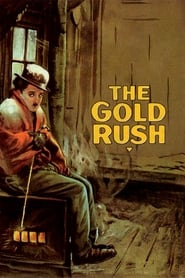

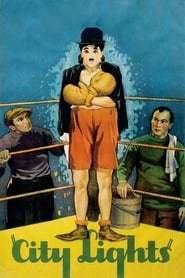

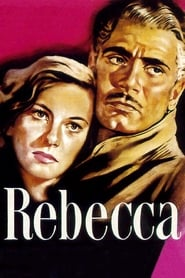

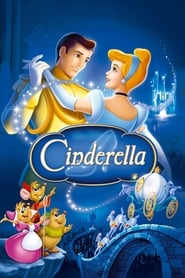

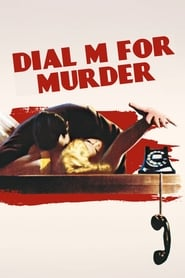

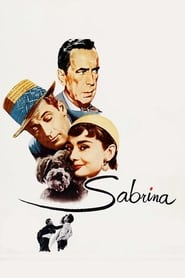

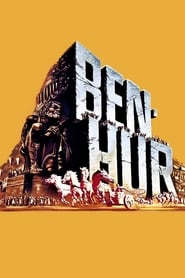

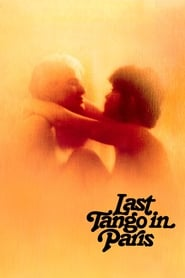

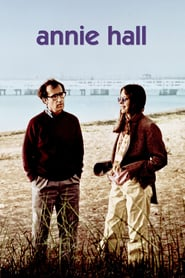

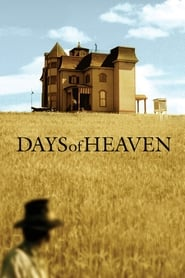

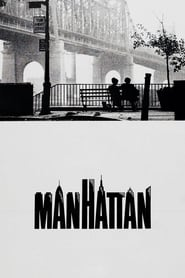

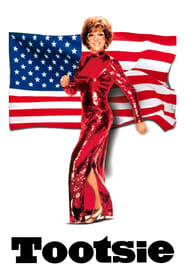

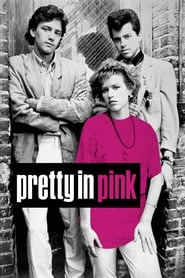

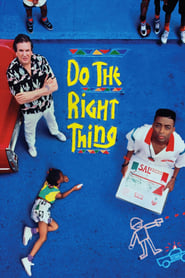

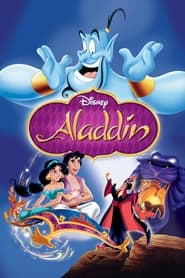

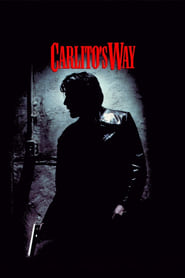

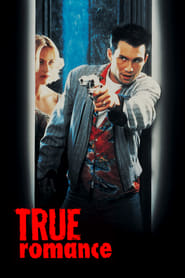

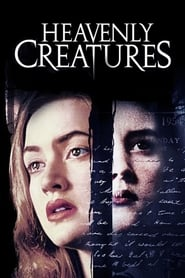

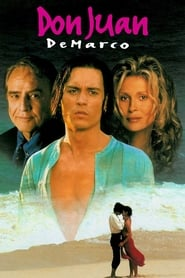

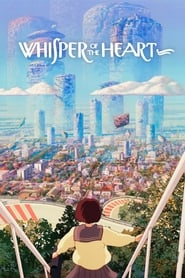

In [67]:
movies_by_keywords("war,love")